### This notebook needs Supplementary Data and Supplementary table 1 

In [1]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, ttest_ind, t
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import math
import pickle
%matplotlib inline

#### Step1: Calculate for all gene pairs in the negative eQTMs the following 4 matrices:
1. co-expression
2. co-methylation
3. CCA-components correlation
4. residual correlations 

In [5]:
# load public datasets for eQTMs
data_prefix = Path("./supplementary_materials/data")
selected_exp_data = np.load(data_prefix/'cca_data/public_expression_eqtms.npy')
selected_exp_rows = [item.strip() for item in open(data_prefix/'cca_data/public_expression_eqtms.rows.txt', 
                                                   'r').readlines()]
selected_exp_cols = [item.strip() for item in open(data_prefix/'cca_data/public_expression_eqtms.cols.txt', 
                                                   'r').readlines()]
selected_exp_df = pd.DataFrame(data=selected_exp_data,
                               index=selected_exp_rows,
                               columns=selected_exp_cols)
print(selected_exp_df.shape)
# load public methylation for eqtms
selected_met_data = np.load(data_prefix/'cca_data/public_methylation_eqtms.npy')
selected_met_rows = [item.strip() for item in open(data_prefix/'cca_data/public_methylation_eqtms.rows.txt', 'r').readlines()]
selected_met_cols = [item.strip().split('_')[0] for item in open(data_prefix/'cca_data/public_methylation_eqtms.cols.txt').readlines()]
selected_met_df = pd.DataFrame(data=selected_met_data,
                               index=selected_met_rows,
                               columns=selected_met_cols)
print(selected_met_df.shape)

# load eQTMs from meta analysis
eqtms = pd.read_excel('supplementarytable1.xlsx')
unique_eqtms = eqtms.sort_values('PValue').drop_duplicates('ProbeName').drop_duplicates('SNPName')
concat_cpgs_set = set(selected_met_df.index)
concat_genes_set = set(selected_exp_df.index)
inConcat = lambda x:True if x[0] in concat_cpgs_set and x[1] in concat_genes_set else False
eqtms['inConcat'] = [inConcat(item) for item in eqtms[['SNPName', 'ProbeName']].values]
valid_eqtms = eqtms[eqtms['inConcat']]
unique_eqtms = valid_eqtms.sort_values('PValue').drop_duplicates('ProbeName').drop_duplicates('SNPName')
print(unique_eqtms.shape)

# load models
def read_pipe_cca(save_prefix, name):
    pipe_exp = pickle.load(open(f'{save_prefix}/preprocessing_for_expression_of_{name}.pkl', 'rb'))
    pipe_met = pickle.load(open(f'{save_prefix}/preprocessing_for_methylation_of_{name}.pkl', 'rb'))
    cca = pickle.load(open(f'{save_prefix}/cca_transformation_for_{name}.pkl', 'rb'))
    return pipe_exp, pipe_met, cca

model_dir = Path("./supplementary_materials/models/cca_transformations")
pipe_negative_expression, pipe_negative_methylation, negative_cca = read_pipe_cca(model_dir, "negative_eqtms")
pipe_positive_expression, pipe_positive_methylation, positive_cca = read_pipe_cca(model_dir, "positive_eqtms")
pipe_unflipped_expression, pipe_unflipped_methylation, unflipped_cca = read_pipe_cca(model_dir, "alleqtms")
pipe_flipped_expression, pipe_flipped_methylation, flipped_cca = read_pipe_cca(model_dir, "alleqtms_flipped")

# calculate CCA components for public datasets
negative_eqtms = unique_eqtms[unique_eqtms['OverallZScore']<=0]
positive_eqtms = unique_eqtms[unique_eqtms['OverallZScore']>=0]
negative_expression = selected_exp_df.loc[negative_eqtms['ProbeName']]
negative_methylation = selected_met_df.loc[negative_eqtms['SNPName']]
positive_expression = selected_exp_df.loc[positive_eqtms['ProbeName']]
positive_methylation = selected_met_df.loc[positive_eqtms['SNPName']]
# cca transformation
cca_negative_expression, cca_negative_methylation = \
negative_cca.transform(pipe_negative_expression.transform(negative_expression),
                       pipe_negative_methylation.transform(negative_methylation))
cca_positive_expression, cca_positive_methylation = \
positive_cca.transform(pipe_positive_expression.transform(positive_expression),
                       pipe_positive_methylation.transform(positive_methylation))
# negative cca transform positive data and vice verse
positivecca_negative_expression, positivecca_negative_methylation = \
positive_cca.transform(pipe_positive_expression.transform(negative_expression),
                       pipe_positive_methylation.transform(negative_methylation))
negativecca_positive_expression, negativecca_positive_methylation = \
negative_cca.transform(pipe_negative_expression.transform(positive_expression),
                       pipe_negative_methylation.transform(positive_methylation))

# Get CCA components correlations for eQTMs
negative_gene_pairs = []
for i, gene1 in enumerate(tqdm(negative_eqtms['ProbeName'])):
    for j in range(i+1, negative_eqtms.shape[0]):
        gene2 = negative_eqtms['ProbeName'].values[j]
        negative_gene_pairs.append(';'.join([gene1, gene2]))
        
exp_triu_corr = spearmanr(cca_negative_expression, axis=1)[0]
met_triu_corr = spearmanr(cca_negative_methylation, axis=1)[0]

corr_flatten_df = pd.DataFrame(data=exp_triu_corr[np.triu_indices_from(exp_triu_corr, 1)],
                               columns=['public_expression'],
                               index=negative_gene_pairs)
corr_flatten_df['public_methylation'] = met_triu_corr[np.triu_indices_from(met_triu_corr, 1)]


negative_exp_corr_df = pd.DataFrame(data=exp_triu_corr,
                                   index=negative_eqtms['ProbeName'].values,
                                    columns=negative_eqtms['ProbeName'].values)
negative_met_corr_df = pd.DataFrame(data=met_triu_corr,
                                   index=negative_eqtms['ProbeName'].values,
                                    columns=negative_eqtms['ProbeName'].values)

# negative_exp_corr_df.to_csv('correlation_summaries/public_CCAexpression_negativeQTMs.tsv', sep='\t')
# negative_met_corr_df.to_csv('correlation_summaries/public_CCAmethylation_negativeQTMs.tsv', sep='\t')

# Regress out the CCA components and calculate the residuals for negative eQTMs
# methylation
residuals_df = pd.DataFrame()
for indidvidual_name in tqdm(negative_methylation.columns):
    X = sm.add_constant(cca_negative_methylation[:, :4])
    model = sm.OLS(negative_methylation[indidvidual_name].values, X)
    results = model.fit()
    residuals_df[indidvidual_name] = results.resid
residuals_df.index = negative_expression.index
# expression
exp_residuals_df = pd.DataFrame()
for indidvidual_name in tqdm(negative_expression.columns):
    X = sm.add_constant(cca_negative_expression[:, :4])
    model = sm.OLS(negative_expression[indidvidual_name].values, X)
    results = model.fit()
    exp_residuals_df[indidvidual_name] = results.resid
exp_residuals_df.index = negative_expression.index
exp_residuals_df.head()

selected_met_df.shape, unique_eqtms.shape, selected_exp_df.shape
unique_eqtm_dic = unique_eqtms.set_index('SNPName')['ProbeName'].T.to_dict()
selected_met_df['probename'] = [unique_eqtm_dic.get(cpgsite) for cpgsite in selected_met_df.index]
selected_met_df = selected_met_df.set_index('probename')
negative_selected_met_df = selected_met_df.loc[residuals_df.index]
negative_selected_met_corr = spearmanr(negative_selected_met_df, axis=1)[0]
negative_selected_met_corr_flatten = negative_selected_met_corr[np.triu_indices_from(negative_selected_met_corr, k=1)]
negative_selected_met_corr_flatten.shape

cpg_residuals_corr_df = pd.DataFrame(data=spearmanr(residuals_df, axis=1)[0],
                                     index=residuals_df.index,
                                     columns=residuals_df.index)
exp_residuals_corr_df = pd.DataFrame(data=spearmanr(exp_residuals_df, axis=1)[0],
                                     index=exp_residuals_df.index,
                                     columns=exp_residuals_df.index)

# cpg_residuals_corr_df.to_csv('correlation_summaries/public_residuals_cpg_negativeQTMs.tsv', sep='\t')
# exp_residuals_corr_df.to_csv('correlation_summaries/public_residuals_gene_negativeQTMs.tsv', sep='\t')

#### Step 2: Add the STRING database labels to the gene-gene pairs
##### to run the following codes, one needs to download the STRING file "9606.protein.links.full.v11.0.txt.gz" from website from: https://string-db.org/cgi/download?sessionId=boERSflD7Ezh

In [20]:
# load STRING database
string_db = pd.read_csv('9606.protein.links.full.v11.0.txt.gz', compression='gzip',
                       sep=" ")
db_map = pd.read_csv('db_protein_ids_with_genenames.txt', sep='\t')
db_map_dict = db_map.dropna(axis=0).set_index('Protein stable ID')['Gene stable ID'].T.to_dict()
string_db['gene1'] = [db_map_dict.get(item.split('.')[1]) for item in string_db['protein1']]
string_db['gene2'] = [db_map_dict.get(item.split('.')[1]) for item in string_db['protein2']]
string_db = string_db.dropna(subset=['gene1', 'gene2'], axis=0)
print(string_db.shape)

eqtm_genes = set(unique_eqtms['ProbeName'])
isineqtm = lambda x:True if x[0] in eqtm_genes and x[1] in eqtm_genes else False
string_db['ineQTM'] = [isineqtm(item) for item in string_db[['gene1', 'gene2']].values]
string_db_subset = string_db[string_db['ineQTM']]
print("STRING with genes in the eQTMs", string_db_subset.shape)

string_db_subset_genepairs = set([';'.join(item) for item in string_db_subset[['gene1', 'gene2']].values])
string_db_subset_genepairs_reverse = set([';'.join(item) for item in string_db_subset[['gene2', 'gene1']].values])
string_db_subset_genepairs_all = string_db_subset_genepairs | string_db_subset_genepairs_reverse
isinString = lambda x:True if x in string_db_subset_genepairs_all else False

string_db_subset['genepair1'] = [';'.join(item) for item in string_db_subset[['gene1', 'gene2']].values]
string_db_subset['genepair2'] = [';'.join(item) for item in string_db_subset[['gene2', 'gene1']].values]

dict1 = string_db_subset.set_index('genepair1').T.to_dict()
dict2 = string_db_subset.set_index('genepair2').T.to_dict()

# check the distribution of low combined_score gene pairs
evidence_cols = ['neighborhood', 'neighborhood_transferred',
       'fusion', 'cooccurence', 'homology', 'coexpression',
       'coexpression_transferred', 'experiments', 'experiments_transferred',
       'database', 'database_transferred', 'textmining',
       'textmining_transferred']

common_genes = list(set(unique_eqtms['ProbeName'].values) & set(bios_cpg_corr_df.index.values) & set(negative_exp_corr_df.index.values))

negative_genepairs = []
for i, gene1 in enumerate(tqdm(common_genes)):
    for j in range(i+1, len(common_genes)):
        gene2 = common_genes[j]
        negative_genepairs.append([gene1, gene2])

corr_res_df = pd.DataFrame(data = negative_genepairs, columns = ['gene1', 'gene2'])

ordered_bios_cpg_corr_df = bios_cpg_corr_df[common_genes].loc[common_genes]
ordered_bios_gene_corr_df = bios_gene_corr_df[common_genes].loc[common_genes]
ordered_public_cpg_corr_df = public_cpg_corr_df[common_genes].loc[common_genes]
ordered_public_gene_corr_df = public_gene_corr_df[common_genes].loc[common_genes]

ordered_public_cca_cpg_corr_df = negative_met_corr_df[common_genes].loc[common_genes]
ordered_public_cca_gene_corr_df = negative_exp_corr_df[common_genes].loc[common_genes]

ordered_cpg_residuals_corr_df = cpg_residuals_corr_df[common_genes].loc[common_genes]
ordered_exp_residuals_corr_df = exp_residuals_corr_df[common_genes].loc[common_genes]

corr_res_df['bios_co_methylation'] = ordered_bios_cpg_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]
corr_res_df['bios_co_expression'] = ordered_bios_gene_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]
corr_res_df['public_co_methylation'] = ordered_public_cpg_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]
corr_res_df['public_co_expression'] = ordered_public_gene_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]

corr_res_df['public_cca_expression'] = ordered_public_cca_cpg_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]
corr_res_df['public_cca_methylation'] = ordered_public_cca_gene_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]

corr_res_df['cpg_residuals'] = ordered_cpg_residuals_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]
corr_res_df['gene_residuals'] = ordered_exp_residuals_corr_df.values[np.triu_indices_from(ordered_bios_cpg_corr_df.values, k=1)]

In [22]:
corr_res_df['inString'] = [isinString(';'.join(item)) for item in corr_res_df[['gene1', 'gene2']].values]

# 2. Get combined score from STRING
def find_combined_score(genepair, col):
    if genepair in dict1:
        return dict1.get(genepair)[col]
    elif genepair in dict2:
        return dict2.get(genepair)[col]
    else:
        return 0
corr_res_df['combined_score'] = [find_combined_score(';'.join(pair), 'combined_score') 
                                 for pair in corr_res_df[['gene1', 'gene2']].values]
corr_res_df['coexpression'] = [find_combined_score(';'.join(pair), 'coexpression') 
                                 for pair in corr_res_df[['gene1', 'gene2']].values]
corr_res_df['database'] = [find_combined_score(';'.join(pair), 'database') 
                                 for pair in corr_res_df[['gene1', 'gene2']].values]
corr_res_df['textmining'] = [find_combined_score(';'.join(pair), 'textmining') 
                                 for pair in corr_res_df[['gene1', 'gene2']].values]
corr_res_df['experiments'] = [find_combined_score(';'.join(pair), 'experiments') 
                                 for pair in corr_res_df[['gene1', 'gene2']].values]

# # get gene name from the mapping file
# gene_id_mapping = pd.read_csv('gene_ids_names.tsv', sep='\t').set_index('Gene stable ID')['Gene name'].T.to_dict()
# eqtms['genename'] = [gene_id_mapping.get(geneid) for geneid in eqtms.ProbeName.values]
# corr_res_df['genename1'] = [gene_id_mapping.get(geneid) for geneid in corr_res_df.gene1.values]
# corr_res_df['genename2'] = [gene_id_mapping.get(geneid) for geneid in corr_res_df.gene2.values]
# corr_res_df.to_csv('correlation_summaries/concated_correlation_values_annotated_withstring.tsv', 
#                    sep='\t', index=False)

#### Alternatively, the correlation values for each gene pair in negative eQTMs with STRING annotation could be downloaded from the supplementary data

In [37]:
corr_res_df = pd.read_csv('./supplementary_materials/data/cca_data/concated_correlation_values_annotated_withstring.tsv', sep='\t')
corr_res_df.head()

,gene1,gene2,bios_co_methylation,bios_co_expression,public_co_methylation,public_co_expression,public_cca_expression,public_cca_methylation,cpg_residuals,gene_residuals,inString,combined_score,coexpression,database,textmining,experiments,genename1,genename2
0,ENSG00000159461,ENSG00000145569,-0.246858,-0.029105,0.116952,-0.125587,-0.212121,-0.090909,0.106522,-0.265941,False,0,0,0,0,0,AMFR,OTULINL
1,ENSG00000159461,ENSG00000211964,0.288300,0.235503,0.468282,-0.018715,0.163636,-0.321212,0.367503,-0.213267,False,0,0,0,0,0,AMFR,IGHV3-48
2,ENSG00000159461,ENSG00000198216,-0.125647,-0.082895,0.065492,0.017952,-0.042424,0.151515,0.054781,-0.220961,False,0,0,0,0,0,AMFR,CACNA1E
3,ENSG00000159461,ENSG00000071462,-0.069349,0.201829,-0.278852,-0.001204,-0.515152,0.115152,-0.227688,0.350041,False,0,0,0,0,0,AMFR,BUD23
4,ENSG00000159461,ENSG00000065054,0.121295,0.060856,0.145479,0.349636,0.066667,0.151515,-0.067046,0.477220,False,0,0,0,0,0,AMFR,SLC9A3R2


#### Step 3: Construct models using the four correlation values for each gene pair to predict whether they exist in STRING

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from time import time

In [40]:
# Set threshold for STRING to 400
thres_combined_score = 400
model_data = pd.concat([corr_res_df[corr_res_df['combined_score']>thres_combined_score],
                        corr_res_df[corr_res_df['combined_score']==0]], axis=0)
model_data = model_data.reset_index(drop=True)

In [43]:
# Scripts below show the Cross-validation training procedures 
aurocs, auprcs = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}, {'exp':[], 'met':[], 'exp_met':[], 'cca': []}
precisions = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}
tprs = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}
models = {}
cv_probs_truths_df = pd.DataFrame()
cca_models = {}

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 800000)

cv = StratifiedKFold(n_splits=5)
for i, (train_index, test_index) in enumerate(cv.split(model_data, model_data['inString'])):
    startime = time()
    print('CV iteration:', i)
    train_x, train_y = model_data.loc[train_index], model_data['inString'].loc[train_index]
    test_x, test_y = model_data.loc[test_index], model_data['inString'].loc[test_index]
    cv_probs_truths_temp = test_y.to_frame()
    cv_probs_truths_temp['gene1'] = model_data['genename1'].loc[test_index]
    cv_probs_truths_temp['gene2'] = model_data['genename2'].loc[test_index]
    probs = {'exp':[], 'met':[], 'exp_met':{}, 'cca': {}}
    # co-exp model
    exp_cols = ['public_co_expression']
    exp_logr = LogisticRegression(class_weight='balanced')
    exp_logr.fit(train_x[exp_cols].values.reshape(-1, 1), train_y)
    exp_probs = exp_logr.predict_proba(test_x[exp_cols].values.reshape(-1, 1))[:, 1].reshape(-1, 1)
    probs['exp'] = exp_probs
    cv_probs_truths_temp['exp_predict'] = exp_probs
    # co-met model
    met_cols = ['public_co_methylation']
    met_logr = LogisticRegression(class_weight='balanced')
    met_logr.fit(abs(train_x[met_cols].values.reshape(-1, 1)), train_y)
    met_probs = met_logr.predict_proba(abs(test_x[met_cols].values.reshape(-1, 1)))[:, 1].reshape(-1, 1)
    probs['met'] = met_probs
    cv_probs_truths_temp['met_predict'] = met_probs
    # co-exp + co-met model
    base_cols = ['public_co_expression', 'public_co_methylation']
    base_logr = LogisticRegression(class_weight='balanced')
    base_logr.fit(train_x[base_cols], train_y)
    base_probs = base_logr.predict_proba(test_x[base_cols])[:, 1].reshape(-1, 1)
    probs['exp_met'] = base_probs
    cv_probs_truths_temp['exp_met_predict'] = base_probs
    # cca model
    cca_cols = ['gene_residuals', 'public_cca_methylation', 'cpg_residuals', 'public_cca_expression']
    cca_logr = LogisticRegression(class_weight='balanced')
    cca_logr.fit(train_x[cca_cols], train_y)
    cca_probs = cca_logr.predict_proba(test_x[cca_cols])[:, 1].reshape(-1, 1)
    probs['cca'] = cca_probs
    cv_probs_truths_temp['cca_predict'] = cca_probs
    cv_probs_truths_temp['CV_round'] = i
    cv_probs_truths_df = pd.concat([cv_probs_truths_df, cv_probs_truths_temp], axis=0)
    cca_models[f'CV_round{i}'] = cca_logr
    # collect the evaluation numbers
    for key in aurocs.keys():
        # roc curve
        fpr, tpr, _ = roc_curve(test_y, probs[key])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs[key].append(interp_tpr)
        aurocs[key].append(roc_auc_score(test_y, probs[key]))
        # precision recall curve
        rec, pre, _ = precision_recall_curve(test_y, probs[key])
        interp_pre = np.interp(mean_recall, rec, pre)
        auprcs[key].append(average_precision_score(test_y, probs[key]))
        precisions[key].append(interp_pre)
    print(f'CV iteration {i} took time {time() - startime}')

CV iteration: 0
CV iteration 0 took time 19.185644149780273
CV iteration: 1
CV iteration 1 took time 18.23488759994507
CV iteration: 2
CV iteration 2 took time 18.887797832489014
CV iteration: 3
CV iteration 3 took time 18.851735591888428
CV iteration: 4
CV iteration 4 took time 19.064258575439453


#### Alternatively Step 3: The CV predictions can be loaded from Supplementary Data

In [47]:
cv_probs_truths_df = pd.read_csv('./supplementary_materials/data/cca_data/string_prediction_5rounds_CV_results.tsv', sep='\t', index_col=0)
cv_probs_truths_df.head()

/groups/umcg-wijmenga/scr02/umcg-sli/methylation/venv3.6/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,String_score_above400,gene1,gene2,exp_predict,met_predict,exp_met_predict,cca_predict,CV_round
0,True,PSMC3,TNFSF14,0.296672,0.536893,0.324911,0.282249,0
1,True,PSMC3,NDUFS3,0.672735,0.514048,0.645050,0.860305,0
2,True,PSMC3,AXIN2,0.394078,0.470836,0.386315,0.548638,0
3,True,PSMC3,RPS2,0.496872,0.508545,0.471773,0.782067,0
4,True,PSMC3,RPL8,0.579299,0.482520,0.563255,0.795042,0


In [52]:
# Get all evaluation metrics for each CV round
aurocs, auprcs = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}, {'exp':[], 'met':[], 'exp_met':[], 'cca': []}
precisions = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}
tprs = {'exp':[], 'met':[], 'exp_met':[], 'cca': []}

mean_fpr = np.linspace(0, 1, 100)
mean_recall = np.linspace(0, 1, 800000)

binarize = lambda x:1 if x else 0
cv_probs_truths_df['label'] = [binarize(item) for item in cv_probs_truths_df['String_score_above400']]
for CV_round in cv_probs_truths_df['CV_round'].unique():
    print('CV iteration:', CV_round)
    test_y = cv_probs_truths_df['label'][cv_probs_truths_df['CV_round']==CV_round]
    probs = {'exp':[], 'met':[], 'exp_met':{}, 'cca': {}}
    probs['exp'] = cv_probs_truths_df['exp_predict'][cv_probs_truths_df['CV_round']==CV_round]
    probs['met'] = cv_probs_truths_df['met_predict'][cv_probs_truths_df['CV_round']==CV_round]
    probs['exp_met'] = cv_probs_truths_df['exp_met_predict'][cv_probs_truths_df['CV_round']==CV_round]
    probs['cca'] = cv_probs_truths_df['cca_predict'][cv_probs_truths_df['CV_round']==CV_round]
    for key in aurocs.keys():
        # roc curve
        fpr, tpr, _ = roc_curve(test_y, probs[key])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs[key].append(interp_tpr)
        aurocs[key].append(roc_auc_score(test_y, probs[key]))
        # precision recall curve
        rec, pre, _ = precision_recall_curve(test_y, probs[key])
        interp_pre = np.interp(mean_recall, rec, pre)
        auprcs[key].append(average_precision_score(test_y, probs[key]))
        precisions[key].append(interp_pre)

CV iteration: 0
CV iteration: 1
CV iteration: 2
CV iteration: 3
CV iteration: 4


Text(0, 0.5, 'Precision')

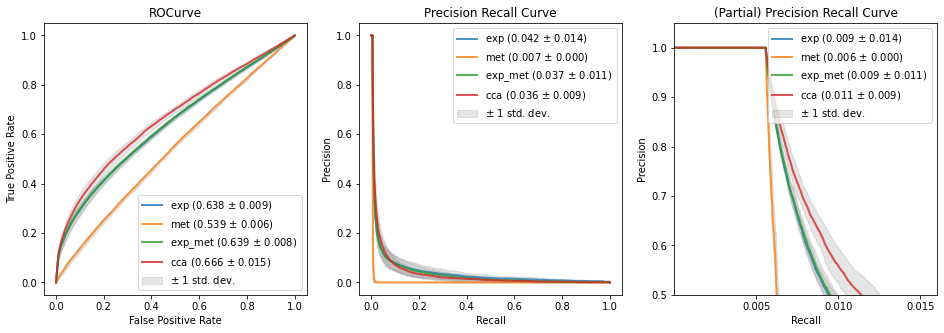

In [53]:
from sklearn.metrics import auc
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
ax1 = axes[0]
for key in tprs.keys():
    mean_tpr = np.mean(tprs[key], axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aurocs[key])
    ax1.plot(mean_fpr, mean_tpr,
            label=f'{key} (%0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)
    std_tpr = np.std(tprs[key], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if key == 'exp':
        ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
    else:
        ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
ax1.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROCurve")
ax1.legend(loc="lower right")
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2 = axes[1]
for key in tprs.keys():
    mean_pre = np.mean(precisions[key], axis=0)
    mean_auprc = auc(mean_recall, mean_pre)
    std_auc = np.std(auprcs[key])
    ax2.plot(mean_recall, mean_pre,
            label=f'{key} (%0.3f $\pm$ %0.3f)' % (mean_auprc, std_auc),
            lw=2, alpha=.8)
    std_pre = np.std(precisions[key], axis=0)
    pre_upper = np.minimum(mean_pre + std_pre, 1)
    pre_lower = np.maximum(mean_pre - std_pre, 0)
    if key == 'exp':
        ax2.fill_between(mean_recall, pre_lower, pre_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
    else:
        ax2.fill_between(mean_recall, pre_lower, pre_upper, color='grey', alpha=.2)
ax2.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
      title="Precision Recall Curve")
ax2.legend(loc="upper right")
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax3 = axes[2]
for key in tprs.keys():
    mean_pre = np.mean(precisions[key], axis=0)
    mean_auprc = auc(mean_recall[mean_pre>0.4], mean_pre[mean_pre>0.4])
    std_auc = np.std(auprcs[key])
    ax3.plot(mean_recall[mean_pre>0.4], mean_pre[mean_pre>0.4],
            label=f'{key} (%0.3f $\pm$ %0.3f)' % (mean_auprc, std_auc),
            lw=2, alpha=.8)
    std_pre = np.std(precisions[key], axis=0)
    pre_upper = np.minimum(mean_pre + std_pre, 1)
    pre_lower = np.maximum(mean_pre - std_pre, 0)
    if key == 'exp':
        ax3.fill_between(mean_recall[mean_pre>0.4], pre_lower[mean_pre>0.4], pre_upper[mean_pre>0.4], 
                        color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
    else:
        ax3.fill_between(mean_recall[mean_pre>0.4], pre_lower[mean_pre>0.4], pre_upper[mean_pre>0.4], 
                        color='grey', alpha=.2)
ax3.set(xlim=[0, 0.016], ylim=[0.5, 1.05],
      title="(Partial) Precision Recall Curve")
ax3.xaxis.set_ticks(np.arange(0.005, 0.016, 0.005))
ax3.legend(loc="upper right")
ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')

# plt.savefig('model_comparison.pdf')
# plt.savefig('model_comparison.png')

#### Alternatively Step 3: The CCA models from each CV round could be found in Supplementary Data

In [57]:
import pickle
cca_models = pickle.load(open('./supplementary_materials/models/cca_transformations/string_prediction_5rounds_models.pkl', 'rb'))

In [73]:
# make predictions using a random selected model from the CV rounds
cca_model = cca_models['CV_round4']
corr_res_df['cca_prob'] = cca_model.predict_proba(corr_res_df[cca_cols])[:, 1]
telllabel = lambda x:1 if x > 400 else 0
corr_res_df['label'] = [telllabel(item) for item in corr_res_df['combined_score']]
print('CCA model applied to all gene pairs:')
print('AUC: ', roc_auc_score(corr_res_df['label'], corr_res_df['cca_prob']))

CCA model applied to all gene pairs:
AUC:  0.6636786109653867
